# Augmenter la netteté d'une image en utilisant la détection de contours

Si l'on s'intéresse aux principes qui sous-tendent la vision humaine, la détection des contours y jouent un rôle primordial. Des méthodes automatiques permettent de détecter des contours dans des images, c'est-à-dire des informations qui permettent de séparer des objets ou des personnes représentés dans une image.

Avant de continuer sur ce notebook, vous devez avoir étudié le notebook sur le flou et découvert la notion de convolution et de masque.

#### Note pour l'enseignant: notion de dérivation

Formellement, la détection de contours est la dérivation (première ou seconde) d'une image, considérée ainsi comme une fonction à 2 variables. Comme ces développements mathématiques ne sont pas au programme de seconde, nous allons simplement considérer les différences entre pixels.


## Objectifs

Les objectifs de ce notebook sont donc:
1. Observer le résultat de détecteurs de contours classiques.
2. Comprendre et appliquer une matrice de convolution permettant la détection de contours.
3. Utiliser les masque de convolution du gradient
4. Augmenter la netteté d'une image

## 1. Analyse des résultats

Dans un premier temps, nous allons utiliser des fonctions fournies par des modules classiques pour observer les résultats. 

* La première méthode est appelée gradient. 
En numérique, un gradient est simplement une différence, et dans le cas des images, c'est la différence entre les intensités de deux pixels voisins:
$$I[x+1,y]-I[x,y]$$

*Sobel* et *Roberts* sont les noms des chercheurs qui les premiers ont utilisé ces opérateurs.


In [12]:
from skimage import filters, data
import matplotlib.pyplot as plt
import scipy.signal as signal
import numpy as np

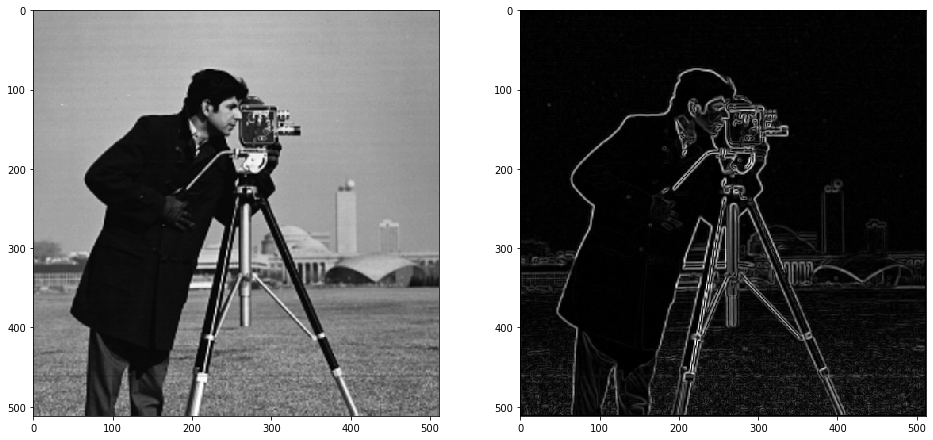

In [9]:
I = data.camera()
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(I, cmap=plt.cm.gray)

edges_sobel = filters.sobel(I)
plt.subplot(122)
plt.imshow(edges_sobel, cmap=plt.cm.gray)
plt.show()

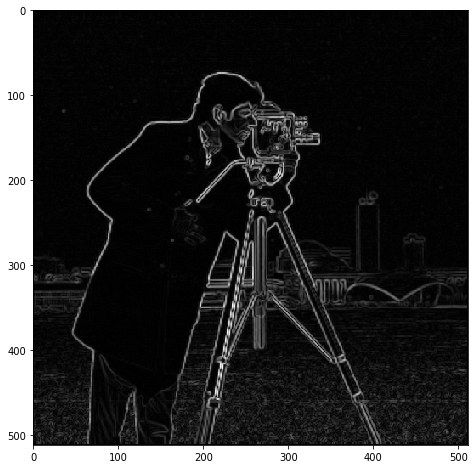

In [25]:
edges_roberts = filters.roberts(I)


plt.figure(figsize=(16,8))
plt.imshow(edges_roberts, cmap=plt.cm.gray)
plt.show()


## 2. Contour directionnel

Comme indiqué précédemment, le gradient est une différence entre deux intensités de pixels voisins:
$$\Delta=I[x+1,y]-I[x,y]$$

Si $(x,y)$ représentent les coordonnées d'un pixel, alors $(x+1,y)$ représentent le voisin de droite. Cette différence n'est pas symétrique, et nous aimerions recentrer le résultat de cette manière:
$$\Delta=I[x+1,y]-I[x-1,y]$$

### Résultat intéressant ?

Si on observe attentivement les images précédentes (notamment dans l'herbe présente sous le caméraman), le résultat est très sensible aux toutes petites variations (on parle de ``bruit`` lorsque les informations perturbent l'objectif escompté). Pour essayer de limiter ce bruit, nous allons moyenner cette différence sur plusieurs lignes:
$$\Delta=(I[x+1,y]+I[x+1,y+1]+I[x+1,y-1]) - (I[x-1,y]+I[x-1,y+1]+I[x-1,y-1])$$

Cette écriture n'est pas très lisible, aussi, nous allons la condenser et l'écrire sous la forme d'une opération de convolution, à la manière de ce qui a été vu sur le calcul du flou. Ainsi, le calcul du gradient selon la direction $x$ sera le résultat de la convolution de l'image avec le masque $h_x$.

$$h_x=\left[\begin{matrix}
-1 & 0 & 1 \\
-1 & 0 & 1 \\
-1 & 0 & 1
\end{matrix}\right]$$

Dans un premier temps, nous allons utiliser une fonction déjà programmée: ``skimage.filters.sobel_h``. Notez bien que le résultat peut être négatif. Pour vérifier que nous obtenons bien les mêmes résultats, l'opposé du filtre de Sobel est calculé.

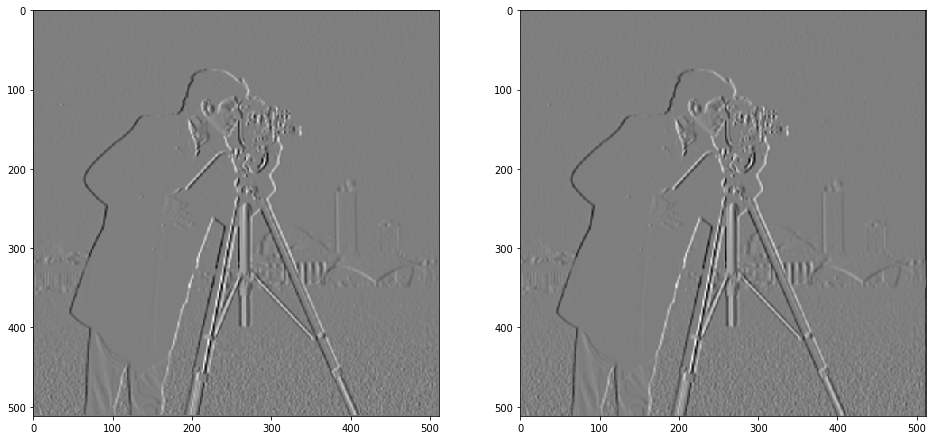

In [16]:
edges_sobel_x = -filters.sobel_v(I);

# Calcul par convolution
hx = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
grad_x = signal.convolve2d(I, hx, 'same')


# Affichage des résultats
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(edges_sobel_x, cmap=plt.cm.gray)
plt.subplot(122)
plt.imshow(grad_x, cmap=plt.cm.gray)
plt.show()

## Seconde direction

Pour réaliser le calcul sur la seconde direction, il suffit d'écrire la différence légèrement différemment.

$$h_y=\left[\begin{matrix}
-1 & -1 & -1 \\
0 & 0 & 0 \\
1 & 1 & 1
\end{matrix}\right]$$

* Amusez vous à changer les coefficients de ce masque et observez les résultats

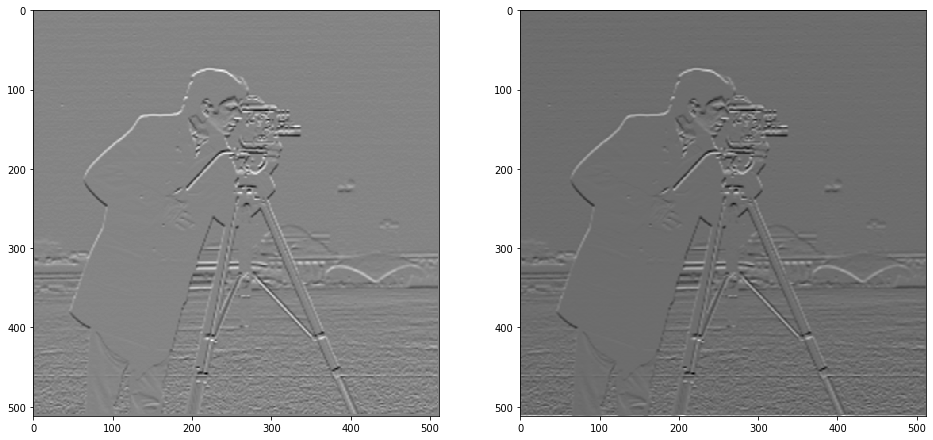

In [17]:
edges_sobel_y = -filters.sobel_h(I);

# Calcul par convolution
hy = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])
grad_y = signal.convolve2d(I, hy, 'same')


# Affichage des résultats
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(edges_sobel_y, cmap=plt.cm.gray)
plt.subplot(122)
plt.imshow(grad_y, cmap=plt.cm.gray)
plt.show()

## Calcul de la norme d'un vecteur

Pour calculer la norme d'un vecteur, on utilise la distance euclidienne classique, c'est-à-dire le théorème de pythagore. Pour un triangle rectangle de côtés de longueurs $a$, $b$ et $c$, $c$ étant la longueur de l'hypothénuse, alors $$c = \sqrt{a^2+b^2}$$.

Considérons que ``a=grad_x`` et ``b=grad_y``, et calculons $c$. La fonction ``np.sqrt`` est la fonction racine carrée.

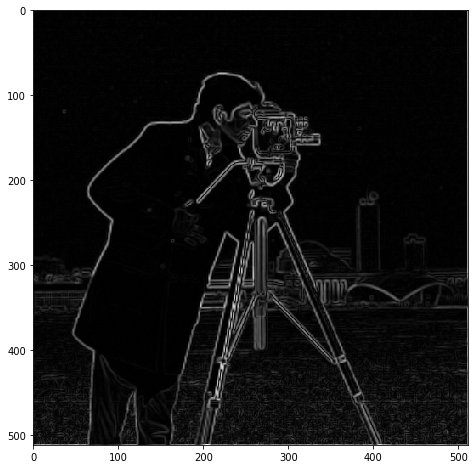

In [23]:
c = np.sqrt(grad_x**2 + grad_y**2)


plt.figure(figsize=(16,8))
plt.imshow(c, cmap=plt.cm.gray)
plt.show()

## Augmentation de la netteté

L'impression de netteté est une sensation qui se base sur la présence de détails. Puisque le calcul précédent fait ressortir ces détails, nous allons renforcer le poids de ceux-ci dans l'image.

Si $I$ est l'image à traiter, et $G$ la norme de son gradient, la formule d'augmentation de la netteté est:
$$N=I + \alpha G$$
avec $\alpha$ un paramètre qui va accentuer ou non la force de l'augmentation.

Pour bien voir le résultat, nous allons tout d'abord rendre floue l'image.

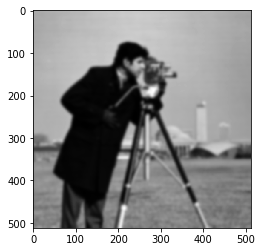

In [55]:
# Pour rendre floue une image, voir le notebook sur le flou
gaussian = filters.gaussian(I, sigma=3)
plt.imshow(gaussian, cmap=plt.cm.gray)
plt.show()

### Détection de contours par laplacien

Le filtre appelé ``laplacien`` est un filtre classique en traitement d'images. Les explications de ce filtre sont en dehors du programme de seconde. Nous allons néanmoins l'utiliser tel quel pour calculer les contours, car il donne dans ce cas un bon résultat.

* Modifiez la valeur du paramètre de flou utilisé précédemment.
* Modifiez la valeur du paramètre $\alpha$ en prenant des valeurs proches de 0 ou des valeurs très grandes


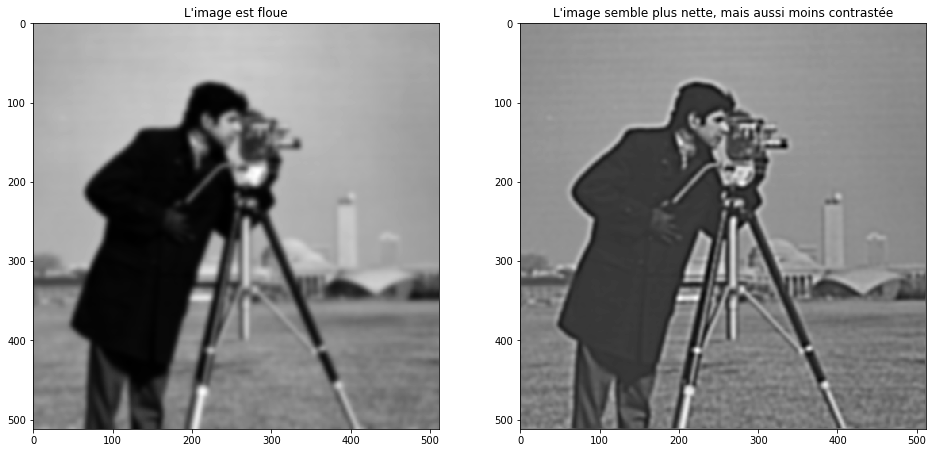

In [60]:
# La fonction fait appel au calcul du laplacien
def nettete(I, alpha):
    G = filters.laplace(I)
    N = I + alpha * G
    return N

N = nettete(gaussian, 15)

plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(gaussian, cmap=plt.cm.gray)
plt.title("L'image est floue")
plt.subplot(122)
plt.imshow(N, cmap=plt.cm.gray)
plt.title("L'image semble plus nette, mais aussi moins contrastée")
plt.show()